In [1]:
import pandas as pd
import re
from parsivar import Normalizer as ParsivarNormalizer
from parsivar import Tokenizer as ParsivarTokenizer
import numpy as np

# Mapping emojis to Persian keywords
emoji_to_persian = {
    '😂': ' خنده ', '🤣': ' خنده ', '😊': ' لبخند ', '😍': ' عشق ', '❤️': ' قلب ', '💕': ' عشق ',
    '👍': ' لایک ', '🔥': ' آتش ', '🙏': ' تشکر ', '🌸': ' گل ', '🎉': ' جشن ',
    '💔': ' قلب_شکسته ', '😔': ' غمگین ', '😞': ' ناامید ', '🙁': ' ناراحت ',
    '🤔': ' تفکر ', '👎': ' دیسلایک ', '😠': ' عصبانی ', '😡': ' عصبانی ', '✅': ' تیک_سبز ',
    '❌': ' ضربدر ', '🌹': ' گل ',
    '😭': ' گریه '
}

positive_keywords_for_cry_emoji = [
    "زیبایی", "زیبا", "خوشبخت", "ناز", "خشکل", "خوش",  "خر" ,"خوشحالی", "جشن", "شادی" , "قشنگ"
    "شوق", "خوشحالی", "خوشحالم", "هیجان", "ذوق", "شاد", "مبارک", "تبریک",
    "عالی", "فوق_العاده", "محشر", "سورپرایز_خوب", "افتخار",  "کیوت" ,"خر"
    "جشن"
]
negative_keywords_for_cry_emoji = [
    "غم", "ناراحت", "اندوه", "دلتنگ", "افسوس", "متاسفم", "تسلیت", "درد","داغ" ,
    "شکست", "باخت", "مصیبت", "فاجعه", "بدبخت", "مرگ", "فوت", "گریه_کنان" , "ناراجتی"
]

contractions_dict = {
    "نمیدونم": "نمی دانم", "نمیخوام": "نمی خواهم", "میدونم": "می دانم",
    "نمیتونم": "نمی توانم", "میتونم": "می توانم", "میشه": "می شود",
    "نمیشه": "نمی شود",  "خوبه": "خوب است", "بریم": "برویم",
    "اینجوری": "این جوری", "اینا": "این ها", "چیه": "چی است", "کیه": "کی است",
    "میرم": "می روم", "نمیام": "نمی آیم", "میام": "می آیم",
    "حالم خوبه": "حال من خوب است", "حال خوبی ندارم": "حال خوبی ندارم",
    "یه": "یک" , 

  
}

# Load dataset
df = pd.read_csv('persian_binary_emotion_dataset.csv')
print("Original shape:", df.shape)
df_processed = df[['hashtags', 'tweet', 'emotion']].copy()
df_processed.rename(
    columns={'tweet': 'tweet_text', 'emotion': 'emotion_label'}, inplace=True
)
df_processed.dropna(inplace=True)

emotion_mapping = {'joy': 0, 'sad': 1}
df_processed['emotion_numeric'] = df_processed['emotion_label'].map(emotion_mapping)

normalizer = ParsivarNormalizer()
tokenizer = ParsivarTokenizer()


# Updated preprocessing function with FIXED order (emoji replacement before normalization)
def preprocess_persian_tweet(text, debug=False):
    if not isinstance(text, str):
        return ""

    original = text

    for contraction, expansion in contractions_dict.items():
        text = text.replace(contraction, expansion)
    if debug: print(f"After manual contractions: '{text}'")

    num_cry_emojis = text.count("😭")
    if num_cry_emojis > 0:
        has_positive = any(keyword in text for keyword in positive_keywords_for_cry_emoji)
        has_negative = any(keyword in text for keyword in negative_keywords_for_cry_emoji)

        replacement_token_for_cry = " گریه " # مقدار پیش‌فرض

        if has_positive and not has_negative:
            replacement_token_for_cry = " اشک_شوق " # یا " ذوق "
        elif has_negative and not has_positive:
            replacement_token_for_cry = " گریه_شدید " 

        text = text.replace("😭", replacement_token_for_cry)
        if debug: print(f"After conditional 😭 replacement: '{text}' (replaced with '{replacement_token_for_cry.strip()}')")

    # Step 2: Replace emojis
    for emoji_char, persian_keyword in emoji_to_persian.items():
        text = text.replace(emoji_char, persian_keyword)

    text = text.replace("_", " ")
    # Step 3: Normalize
    text = normalizer.normalize(text)

    #  debug print
    if debug:
        print("Original:", original)
        print("Emoji replaced + normalized:", text)

    # Step 4: Reduce character repetition
    text = re.sub(r"(.)\1{3,}", r"\1\1\1", text)

    # Step 5: Remove mentions, URLs, hashtags (only '#' symbol)
    text = re.sub(r"@[^\s]+", "", text)
    text = re.sub(r"#([^\s]+)", r"\1", text)
    text = re.sub(r"http\S+", "", text)



    # Step 7: Remove non-Persian characters (but keep "ایموجی_" style tokens)
    text = re.sub(
        r"[^\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\U0001EE00-\U0001EEFF\u200C\s\d_؟!?]",
        "",
        text,
        flags=re.UNICODE,
    )

    text_to_token = text.replace("_", " ")
    # Step 8: Tokenize and clean
    tokens = tokenizer.tokenize_words(text_to_token)
    tokens = [t.strip() for t in tokens if len(t.strip()) >=1]
    return " ".join(tokens)


def extract_hashtag_content_updated(hashtag_text):
    if not isinstance(hashtag_text, str):
        return ""
    try:
        content = hashtag_text.strip("[]'\" ")
        tags = [tag.strip() for tag in content.split(",")]
        cleaned_tags = [tag.strip("'\" ").lstrip("#") for tag in tags if tag]
        joined_hashtags = " ".join(cleaned_tags)
    except Exception as e:
        print(f"Error processing hashtag string: {hashtag_text} - Error: {e}")
        joined_hashtags = hashtag_text.strip("[]'\" ")
    return preprocess_persian_tweet(joined_hashtags)



print("\nPreprocessing tweets and hashtags...")
df_processed["cleaned_tweet"] = df_processed["tweet_text"].apply(
    preprocess_persian_tweet
)
df_processed["cleaned_hashtags"] = df_processed["hashtags"].apply(
    extract_hashtag_content_updated
)


def is_valid_cleaned_tweet(text):
    return isinstance(text, str) and len(text.strip()) >= 5 and len(text.split()) >= 2


valid_tweets_mask = df_processed["cleaned_tweet"].apply(is_valid_cleaned_tweet)
valid_hashtags_mask = df_processed["cleaned_hashtags"].apply(
    lambda x: isinstance(x, str) and len(x.strip()) > 0
)
df_processed = df_processed[valid_tweets_mask & valid_hashtags_mask].reset_index(
    drop=True
)

df_processed["full_text"] = (
    df_processed["cleaned_tweet"] + " " + df_processed["cleaned_hashtags"].fillna("")
)

# Debug single tweet
print("\nExample output for index 3:")
print("Original:", df_processed.iloc[3]["tweet_text"])
print("Processed:", df_processed.iloc[3]["full_text"])

# Preview
print("\nSample outputs:")
print(df_processed[["tweet_text", "full_text"]].head().to_string())


Original shape: (62352, 8)

Preprocessing tweets and hashtags...

Example output for index 3:
Original: دلم نیومد امشب تموم بشه و نگم 
حاج قاسمم سردارم؛ 
ما شادی امشبمون رو بشدت به شما مدیونیم🌹 
و فقط خدا می‌دونه چقدر دلتنگ اون تبسم‌های شیرین شماییم 😭😭😭...
#جشن_ملت_ایران
Processed: دلم نیومد امشب تموم بشه و نگم حاج قاسمم سردارم ؛ ما شادی امشبمون رو بشدت به شما مدیونیم گل و فقط خدا می‌دونه چقدر دلتنگ اون تبسم‌های شیرین شماییم گریه گریه گریه جشن ملت ایران جشن ملت ایران

Sample outputs:
                                                                                                                                                                                                                                                                                     tweet_text                                                                                                                                                                                                                                

In [2]:
df_processed.head()

,hashtags,tweet_text,emotion_label,emotion_numeric,cleaned_tweet,cleaned_hashtags,full_text
0,['ویگن'],با تو رفتم بی تو باز امدم\nاز سر کوی او«دل دیو...,sad,1,با تو رفتم بی‌تو باز امدم از سر کوی او دل دیوا...,ویگن,با تو رفتم بی‌تو باز امدم از سر کوی او دل دیوا...
1,['دگرباشان'],آنتونی بلینکن، وزیر خارجه ایالات متحده آمریکا،...,joy,0,آنتونی بلینکن ، وزیر خارجه ایالات متحده آمریکا...,دگرباشان,آنتونی بلینکن ، وزیر خارجه ایالات متحده آمریکا...
2,['امام_رضا'],شب شده بودحال روحیم خوب نبود،همین که اومدم از ...,joy,0,شب‌شده‌بودحال روحیم خوب نبود ، همین که اومدم ا...,امام رضا,شب‌شده‌بودحال روحیم خوب نبود ، همین که اومدم ا...
3,['جشن_ملت_ایران'],دلم نیومد امشب تموم بشه و نگم \nحاج قاسمم سردا...,joy,0,دلم نیومد امشب تموم بشه و نگم حاج قاسمم سردارا...,جشن ملت ایران,دلم نیومد امشب تموم بشه و نگم حاج قاسمم سردارا...
4,"['مردم_میدان', 'وحدت_برای_آبادانی']",جشن تکلیف سیاسی رأی اولی ها مبارک... #مردم_...,joy,0,جشن تکلیف سیاسی رای اولی‌ها مبارک مردم میدان و...,مردم میدان وحدت برای آبادانی,جشن تکلیف سیاسی رای اولی‌ها مبارک مردم میدان و...


In [2]:
# این بخش را قبل از ایجاد emotion_numeric اضافه کنید
df_processed['emotion_label'] = df_processed['emotion_label'].str.strip()

In [3]:
y = df_processed['emotion_numeric'].values # .values آن را به آرایه NumPy تبدیل می‌کند
print(f"y dtype after creation: {y.dtype}, Sample y: {y[:10]}")

y dtype after creation: int64, Sample y: [1 0 0 0 0 1 1 1 0 1]


In [4]:
y = y.astype(np.int32) 


In [5]:
df_processed.columns


Index(['hashtags', 'tweet_text', 'emotion_label', 'emotion_numeric',
       'cleaned_tweet', 'cleaned_hashtags', 'full_text'],
      dtype='object')

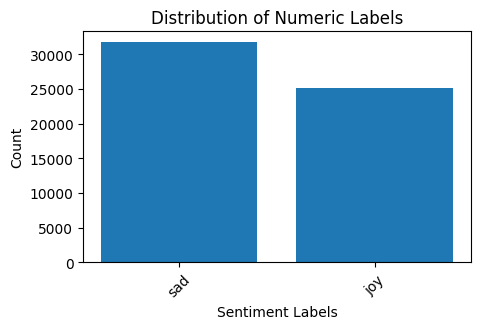

Label distribution: Counter({1: 31715, 0: 25150})


In [7]:
from collections import Counter
import matplotlib.pyplot as plt

label_counts = Counter(df_processed['emotion_numeric'])
labels, counts = zip(*label_counts.items())

label_mapping = dict(zip(df_processed['emotion_numeric'], df_processed['emotion_label']))
label_names = [label_mapping.get(label, f"Label {label}") for label in labels]

plt.figure(figsize=(5, 3))
plt.bar(label_names, counts)
plt.title('Distribution of Numeric Labels')
plt.xlabel('Sentiment Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Print counts for reference
print("Label distribution:", label_counts)

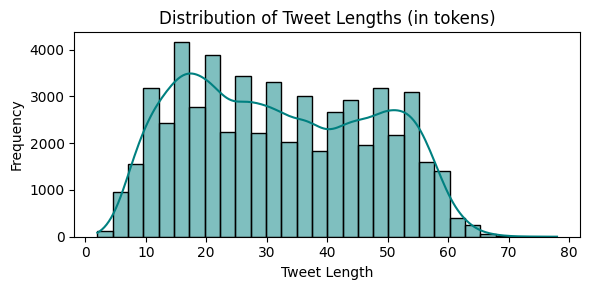

In [8]:
import seaborn as sns
# Calculate tweet lengths
df_processed['tweet_length'] = df_processed['cleaned_tweet'].apply(lambda x: len(x.split()))

# Plot length distribution
plt.figure(figsize=(6, 3))
sns.histplot(df_processed['tweet_length'], bins=30, kde=True, color='teal')
plt.title("Distribution of Tweet Lengths (in tokens)")
plt.xlabel("Tweet Length")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [41]:
df_processed.columns

Index(['hashtags', 'tweet_text', 'emotion_label', 'emotion_numeric',
       'cleaned_tweet', 'cleaned_hashtags', 'full_text'],
      dtype='object')

.این قسمت پایین در پیش پردازش اعمال شد

In [ ]:
# # from parsivar import Normalizer, Tokenizer
# stopwords = set(open("stopwords.txt", encoding="utf-8").read().splitlines())

# def remove_stopwords(text):
#     words = text.split()
#     return " ".join([word for word in words if word not in stopwords])

# df_processed['full_text'] = df_processed['full_text'].apply(remove_stopwords)


In [11]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import arabic_reshaper
from bidi.algorithm import get_display
import re

def plot_top_words(df, emotion_label, font_path, top_n=20):
    
    texts = df[df['emotion_label'] == emotion_label]['full_text']


    all_text = " ".join(texts)

    all_text = re.sub(r'[^\u0600-\u06FF\s]', '', all_text)

 
    words = all_text.split()

    word_freq = Counter(words)

    most_common = word_freq.most_common(top_n)
    words, freqs = zip(*most_common)

    reshaped_words = [get_display(arabic_reshaper.reshape(w)) for w in words]

    font_prop = fm.FontProperties(fname=font_path)

    plt.figure(figsize=(8, 4))
    sns.barplot(x=list(freqs), y=reshaped_words)
    plt.xlabel("Frequency", fontsize=8)
    plt.ylabel("Words", fontsize=8)
    plt.title(f"Top words in {emotion_label} tweets", fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8, fontproperties=font_prop)
    plt.tight_layout()
    plt.show()


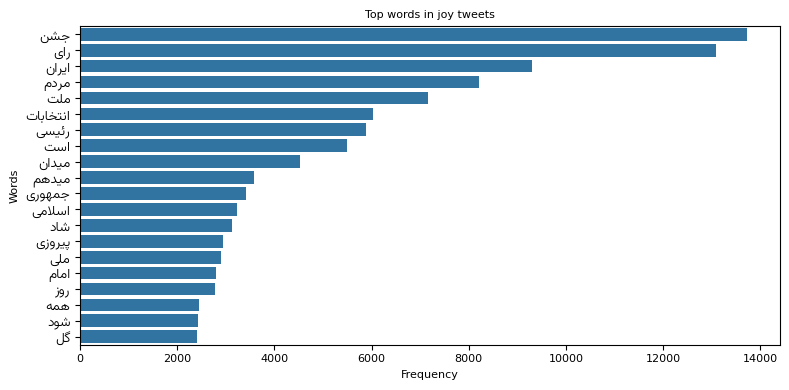

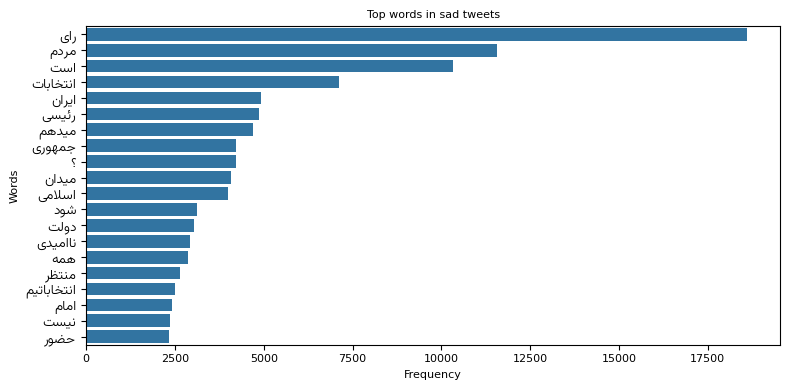

In [12]:
font_path = "ttf/Vazirmatn-Light.ttf"

# For joy tweets
plot_top_words(df_processed, emotion_label="joy", font_path=font_path)

# For sad tweets
plot_top_words(df_processed, emotion_label="sad", font_path=font_path)


1. Tokenizing and Padding

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters
MAX_NUM_WORDS = 20000  # Max vocabulary size
MAX_SEQUENCE_LENGTH = 100  # Max tweet length after padding

# Tokenize text
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df_processed['full_text'])
sequences = tokenizer.texts_to_sequences(df_processed['full_text'])

# Pad sequences
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

####################################

print(f"X dtype after creation: {X.dtype}, X shape: {X.shape}")
####################################

# Labels



X dtype after creation: int32, X shape: (56865, 100)


In [16]:
# print("Tokenizing and padding sequences for X...")
# sequences = tokenizer.texts_to_sequences(df_processed['full_text'])
# X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
# print(f"X dtype after creation: {X.dtype}, X shape: {X.shape}")

2.Loading FastText Embeddings and Creating Embedding Matrix

In [6]:


EMBEDDING_DIM = 300
embedding_index = {}

with open('cc.fa.300.vec', 'r', encoding='utf-8') as f:
    next(f)  # skip header
    for line in f:
        values = line.rstrip().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs


3. Creating Embedding Matrix for the vcabulary


In [7]:
from tensorflow.keras.layers import Embedding

word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

#######################################################
found_words = 0
total_words_in_vocab = 0

for word, i in word_index.items():
    if i < num_words: # num_words معمولا MAX_NUM_WORDS یا len(word_index)+1 است
        total_words_in_vocab += 1
        if embedding_index.get(word) is not None:
            found_words += 1

if total_words_in_vocab > 0:
    coverage_percentage = (found_words / total_words_in_vocab) * 100
    print(f"Words in tokenizer vocabulary (up to num_words): {total_words_in_vocab}")
    print(f"Words found in FastText embedding: {found_words}")
    print(f"FastText vocabulary coverage: {coverage_percentage:.2f}%")
else:
    print("Tokenizer vocabulary is empty or num_words is 0.")        


Words in tokenizer vocabulary (up to num_words): 19999
Words found in FastText embedding: 19023
FastText vocabulary coverage: 95.12%


In [8]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (45492, 100)
Test shape: (11373, 100)


In [9]:

X_train = X_train.astype(np.int32) # یا np.float64
X_test = X_test.astype(np.int32)  

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)


In [10]:
print(f"X_train dtype: {X_train.dtype}")
print(f"y_train dtype: {y_train.dtype}")


X_train dtype: int32
y_train dtype: int32


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 

In [ ]:
###افراضات
# labels باد قبلاً تعریف شده باشد، برای مثال:
# labels = ['joy', 'sad']
# num_classes = len(labels) # باید ۲ باشد
# فرض می‌کنیم MAX_SEQUENCE_LENGTH و embedding_matrix قبلاً آماده شده‌اند


setting up evaluation functions . 

In [12]:
def evaluate_model(model, X_test, y_test, labels, model_name="Model"):
    print(f"\n--- Evaluation: {model_name} ---")
    y_pred = model.predict(X_test)
    # اگر خروجی سیگموئید است، برای تبدیل به کلاس‌ها
    if y_pred.shape[-1] == 1: # خروجی سیگموئید
        y_pred_classes = (y_pred > 0.5).astype("int32").flatten()
    else: # خروجی سافت‌مکس
        y_pred_classes = y_pred.argmax(axis=1)

    acc = accuracy_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes, average='macro')

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score (macro): {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred_classes, target_names=labels))

    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return acc, f1

In [13]:
import matplotlib.pyplot as plt
import pandas as pd 
import matplotlib.font_manager as fm
import arabic_reshaper  # برای شکل‌دهی صحیح حروف فارسی
from bidi.algorithm import get_display # برای نمایش راست به چپ


font_path = "ttf/Vazirmatn-Light.ttf" 
try:
    persian_font_properties = fm.FontProperties(fname=font_path, size=12)
    print(f"فونت بارگذاری شد: {persian_font_properties.get_name()}")
except RuntimeError:
    print(f"فونت در مسیر '{font_path}' یافت نشد یا قابل بارگذاری نیست. از فونت پیش‌فرض استفاده می‌شود.")
    persian_font_properties = fm.FontProperties(size=12) 

def prepare_persian_text_for_plot(text):
    reshaped_text = arabic_reshaper.reshape(text)
    bidi_text = get_display(reshaped_text)
    return bidi_text


def plot_learning_curves(history_object, model_name="مدل"):
    
    if not hasattr(history_object, 'history') or not isinstance(history_object.history, dict):
        print(prepare_persian_text_for_plot("ورودی 'history_object' معتبر نیست یا فاقد کلید 'history' است."))
        return

    history_data = history_object.history

    plt.figure(figsize=(14, 6))

    # نمودار دقت
    plt.subplot(1, 2, 1)
    if 'accuracy' in history_data:
        plt.plot(history_data['accuracy'], label=prepare_persian_text_for_plot('دقت آموزش'))
    if 'val_accuracy' in history_data:
        plt.plot(history_data['val_accuracy'], label=prepare_persian_text_for_plot('دقت اعتبارسنجی'))

    plt.title(prepare_persian_text_for_plot(f'نمودار دقت {model_name}'), fontproperties=persian_font_properties)
    plt.xlabel(prepare_persian_text_for_plot('ایپاک'), fontproperties=persian_font_properties)
    plt.ylabel(prepare_persian_text_for_plot('دقت'), fontproperties=persian_font_properties)

    # اضافه کردن لجند بشرط حضور حداقل یک خط
    if 'accuracy' in history_data or 'val_accuracy' in history_data:
        legend = plt.legend(prop=persian_font_properties)
        if legend:
            for text_obj in legend.get_texts():
                text_obj.set_fontproperties(persian_font_properties)
    plt.grid(True)

    # نمودار خطا
    plt.subplot(1, 2, 2)
    if 'loss' in history_data:
        plt.plot(history_data['loss'], label=prepare_persian_text_for_plot('خطای آموزش'))
    if 'val_loss' in history_data:
        plt.plot(history_data['val_loss'], label=prepare_persian_text_for_plot('خطای اعتبارسنجی'))

    plt.title(prepare_persian_text_for_plot(f'نمودار خطای {model_name}'), fontproperties=persian_font_properties)
    plt.xlabel(prepare_persian_text_for_plot('ایپاک'), fontproperties=persian_font_properties)
    plt.ylabel(prepare_persian_text_for_plot('خطا'), fontproperties=persian_font_properties)

    #  اضافه کردن لجند بشرط حضور حداقل یک خط
    if 'loss' in history_data or 'val_loss' in history_data:
        legend = plt.legend(prop=persian_font_properties)
        if legend:
            for text_obj in legend.get_texts():
                text_obj.set_fontproperties(persian_font_properties)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

فونت بارگذاری شد: Vazirmatn


In [81]:
labels = ['joy', 'sad']  

In [14]:
print("\n--- Defining Model 1: Simple LSTM ---")
def build_super_simple_lstm_model(embedding_matrix, max_sequence_length):
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0],
                        output_dim=embedding_matrix.shape[1],
                        weights=[embedding_matrix],
                        input_length=max_sequence_length,
                        trainable=False))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.001) #default
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

super_simple_lstm_model = build_super_simple_lstm_model(embedding_matrix, MAX_SEQUENCE_LENGTH)



--- Defining Model 1: Simple LSTM ---


f:\datamining-chapter3\New folder\venv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [15]:
print("\n--- Training Model 1: Simple LSTM ---")
history_super_simple_lstm = super_simple_lstm_model.fit(X_train, y_train,
                                            epochs=15,
                                            batch_size=64,
                                            validation_data=(X_test, y_test),
                                            verbose=1)

evaluate_model(super_simple_lstm_model, X_test, y_test, labels, model_name="Super Simple LSTM")


--- Training Model 1: Simple LSTM ---
Epoch 1/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 61s 79ms/step - accuracy: 0.5762 - loss: 0.6794 - val_accuracy: 0.5577 - val_loss: 0.6882
Epoch 2/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 52s 73ms/step - accuracy: 0.5581 - loss: 0.6870 - val_accuracy: 0.5577 - val_loss: 0.6865
Epoch 3/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 57s 80ms/step - accuracy: 0.5587 - loss: 0.6866 - val_accuracy: 0.5577 - val_loss: 0.6869
Epoch 4/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 55s 78ms/step - accuracy: 0.5563 - loss: 0.6870 - val_accuracy: 0.5577 - val_loss: 0.6873
Epoch 5/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 51s 71ms/step - accuracy: 0.5610 - loss: 0.6861 - val_accuracy: 0.5577 - val_loss: 0.6867
Epoch 6/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 45s 63ms/step - accuracy: 0.5557 - loss: 0.6872 - val_accuracy: 0.5577 - val_loss: 0.6865
Epoch 7/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 54s 76ms/step - accuracy: 0.5628 - loss: 0.6853 - val_accuracy: 0.5577 - val_loss: 0.6867
Epoch 8/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 49s 69ms/st

NameError: name 'labels' is not defined

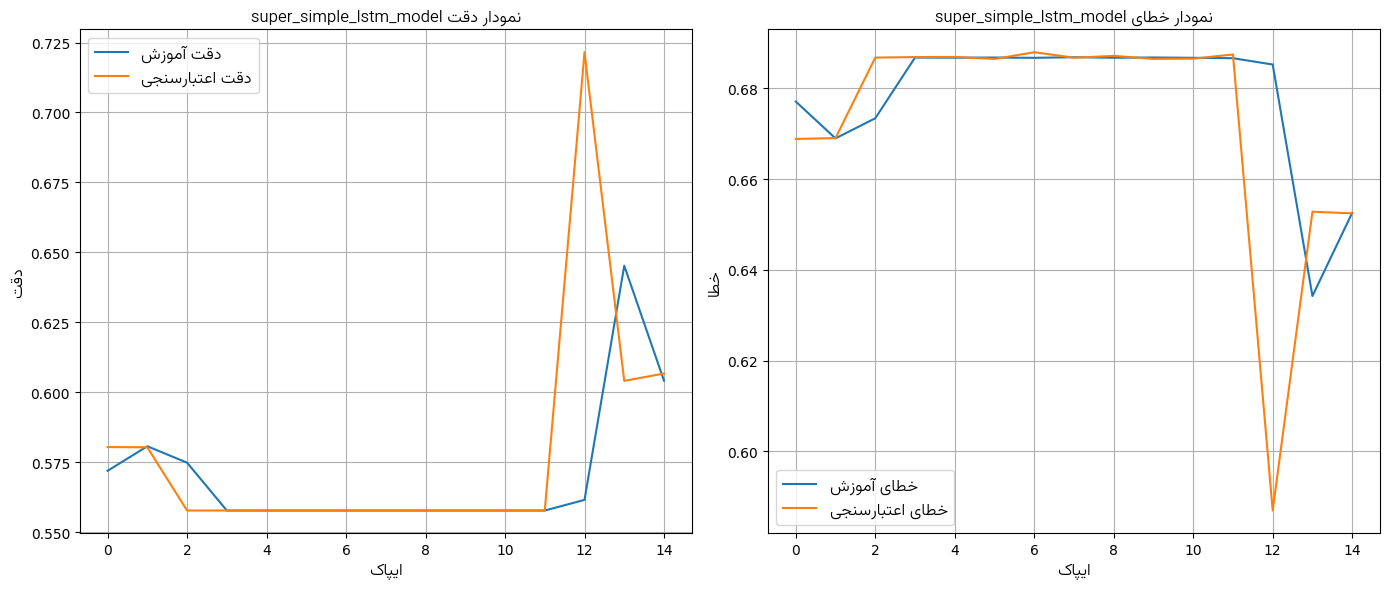

In [67]:
plot_learning_curves(history_super_simple_lstm, model_name="super_simple_lstm_model")

In [15]:
print("\n--- Defining Model 1: Simple LSTM ---")
def build_simple_lstm_model(embedding_matrix, max_sequence_length):
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0],
                        output_dim=embedding_matrix.shape[1],
                        weights=[embedding_matrix],
                        input_length=max_sequence_length,
                        trainable=False))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.0002)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

simple_lstm_model_V1 = build_simple_lstm_model(embedding_matrix, MAX_SEQUENCE_LENGTH)



--- Defining Model 1: Simple LSTM ---


f:\datamining-chapter3\New folder\venv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



--- Training Model 1: Simple LSTM ---
Epoch 1/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 81s 107ms/step - accuracy: 0.6359 - loss: 0.6129 - val_accuracy: 0.8434 - val_loss: 0.3646
Epoch 2/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 76s 106ms/step - accuracy: 0.8516 - loss: 0.3514 - val_accuracy: 0.8651 - val_loss: 0.3244
Epoch 3/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 89s 126ms/step - accuracy: 0.8691 - loss: 0.3212 - val_accuracy: 0.8592 - val_loss: 0.3287
Epoch 4/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 92s 130ms/step - accuracy: 0.8745 - loss: 0.3073 - val_accuracy: 0.8676 - val_loss: 0.3635
Epoch 5/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 66s 93ms/step - accuracy: 0.8821 - loss: 0.2964 - val_accuracy: 0.8894 - val_loss: 0.2802
Epoch 6/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 67s 95ms/step - accuracy: 0.8919 - loss: 0.2791 - val_accuracy: 0.8947 - val_loss: 0.2735
Epoch 7/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 64s 90ms/step - accuracy: 0.9031 - loss: 0.2577 - val_accuracy: 0.9034 - val_loss: 0.2520
Epoch 8/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 64s 90m

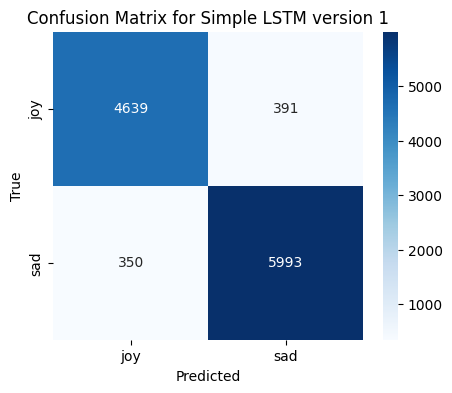

(0.9348456871537852, 0.9339089234030419)

In [16]:
print("\n--- Training Model 1: Simple LSTM ---")
history_simple_lstm_V1 = simple_lstm_model_V1.fit(X_train, y_train,
                                            epochs=15,
                                            batch_size=64,
                                            validation_data=(X_test, y_test),
                                            verbose=1)

evaluate_model(simple_lstm_model_V1, X_test, y_test, labels, model_name="Simple LSTM version 1")

In [64]:
print("\n--- Defining Model 1: Simple LSTM ---")
def build_simple_lstm_model(embedding_matrix, max_sequence_length):
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0],
                        output_dim=embedding_matrix.shape[1],
                        weights=[embedding_matrix],
                        input_length=max_sequence_length,
                        trainable=False))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.0004)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

simple_lstm_model = build_simple_lstm_model(embedding_matrix, MAX_SEQUENCE_LENGTH)



--- Defining Model 1: Simple LSTM ---


f:\datamining-chapter3\New folder\venv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [65]:
print("\n--- Training Model 1: Simple LSTM ---")
history_simple_lstm = simple_lstm_model.fit(X_train, y_train,
                                            epochs=15,
                                            batch_size=64,
                                            validation_data=(X_test, y_test),
                                            verbose=1)

evaluate_model(simple_lstm_model, X_test, y_test, labels, model_name="Simple LSTM")


--- Training Model 1: Simple LSTM ---
Epoch 1/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 86s 115ms/step - accuracy: 0.5988 - loss: 0.6653 - val_accuracy: 0.6772 - val_loss: 0.6147
Epoch 2/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 85s 119ms/step - accuracy: 0.6504 - loss: 0.6382 - val_accuracy: 0.5577 - val_loss: 0.6808
Epoch 3/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 86s 121ms/step - accuracy: 0.5584 - loss: 0.6810 - val_accuracy: 0.5577 - val_loss: 0.6804
Epoch 4/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 80s 113ms/step - accuracy: 0.5559 - loss: 0.6810 - val_accuracy: 0.5577 - val_loss: 0.6809
Epoch 5/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 92s 130ms/step - accuracy: 0.5567 - loss: 0.6817 - val_accuracy: 0.5577 - val_loss: 0.6806
Epoch 6/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 81s 114ms/step - accuracy: 0.5629 - loss: 0.6745 - val_accuracy: 0.5577 - val_loss: 0.6646
Epoch 7/15
332/711 ━━━━━━━━━━━━━━━━━━━━ 38s 102ms/step - accuracy: 0.5564 - loss: 0.6654

KeyboardInterrupt: 

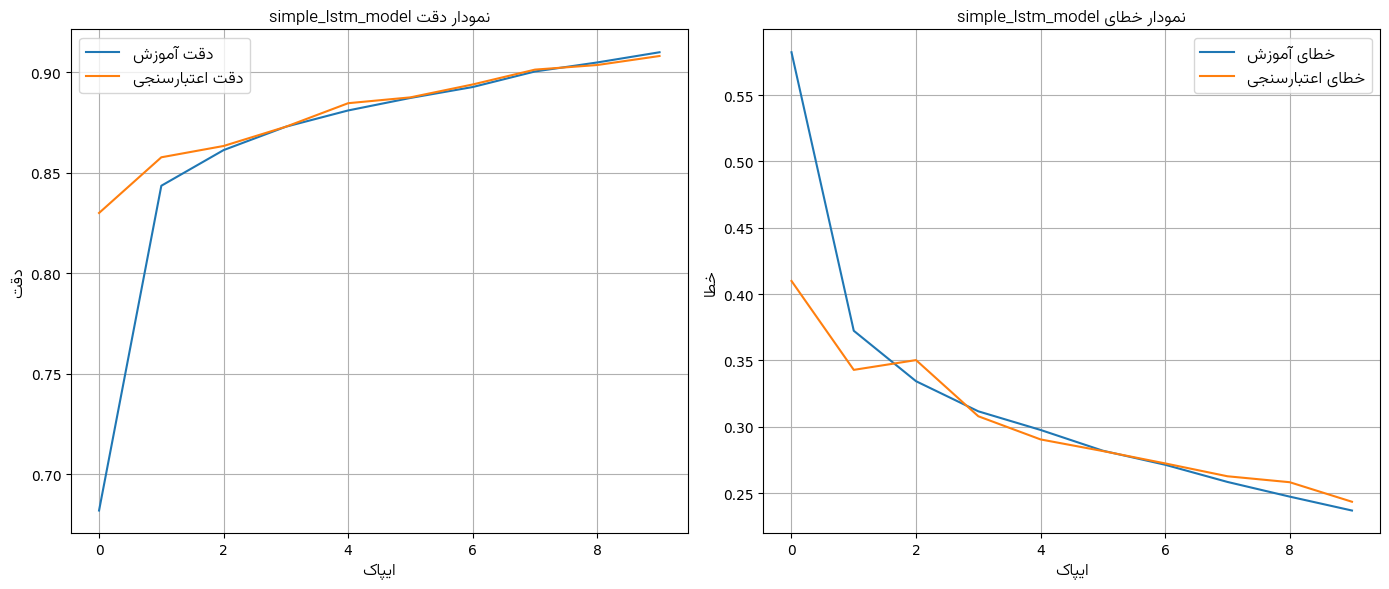

In [87]:
plot_learning_curves(history_simple_lstm, model_name="simple_lstm_model")

تا همینجای کار تفاوت بین نرخ یادگیری 0.0002 و 0.0004 در کد بالا نشوندهنده ی عملکرد عالی در ابتدا و شر,ع بیش برازش، عملکرد خوب و تعیمم پذیر ولی جای بهبودی وجود دارد. با توجه به همین بررسی اپدیت زیر رو انجام میدیم. (با توجه به اینکه دیگه پارامتر ها ثابت بود ))

شروع نرخ یادگیری اولیه با 0.0003. مصالحه بین دو مقدار قبلی

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [20]:
print("\n--- Defining Model with Callbacks: LSTM with LR Scheduler & Early Stopping ---")
def build_lstm_model_with_callbacks(embedding_matrix, max_sequence_length, initial_lr=0.0003): # نرخ یادگیری اولیه به عنوان آرگومان
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0],
                        output_dim=embedding_matrix.shape[1],
                        weights=[embedding_matrix],
                        input_length=max_sequence_length,
                        trainable=False)) 
    model.add(LSTM(64, return_sequences=False)) 
    # model.add(Dropout(0.3)) # برای کاهش بیش براز ش میتونیم اضاف کنیم
    model.add(Dense(1, activation='sigmoid')) 

    optimizer = Adam(learning_rate=initial_lr) # استفاده از نرخ یادگیری اولیه
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

initial_learning_rate = 0.0003
lstm_model_cb = build_lstm_model_with_callbacks(embedding_matrix, MAX_SEQUENCE_LENGTH, initial_lr=initial_learning_rate)



--- Defining Model with Callbacks: LSTM with LR Scheduler & Early Stopping ---



--- Training Model with Callbacks (Initial LR: 0.0003) ---
Epoch 1/20
711/711 ━━━━━━━━━━━━━━━━━━━━ 57s 80ms/step - accuracy: 0.9618 - loss: 0.1047 - val_accuracy: 0.9481 - val_loss: 0.1442 - learning_rate: 3.0000e-04
Epoch 2/20
711/711 ━━━━━━━━━━━━━━━━━━━━ 61s 86ms/step - accuracy: 0.9629 - loss: 0.1009 - val_accuracy: 0.9500 - val_loss: 0.1520 - learning_rate: 3.0000e-04
Epoch 3/20
711/711 ━━━━━━━━━━━━━━━━━━━━ 64s 90ms/step - accuracy: 0.9625 - loss: 0.0989 - val_accuracy: 0.9519 - val_loss: 0.1345 - learning_rate: 3.0000e-04
Epoch 4/20
711/711 ━━━━━━━━━━━━━━━━━━━━ 90s 101ms/step - accuracy: 0.9649 - loss: 0.0958 - val_accuracy: 0.9514 - val_loss: 0.1338 - learning_rate: 3.0000e-04
Epoch 5/20
711/711 ━━━━━━━━━━━━━━━━━━━━ 59s 83ms/step - accuracy: 0.9674 - loss: 0.0889 - val_accuracy: 0.9509 - val_loss: 0.1352 - learning_rate: 3.0000e-04
Epoch 6/20
711/711 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9673 - loss: 0.0907
Epoch 6: ReduceLROnPlateau reducing learning rate to 6.000000

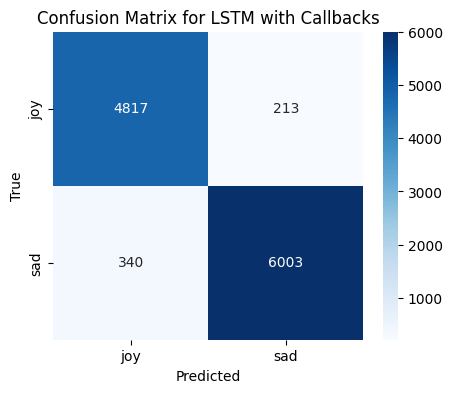

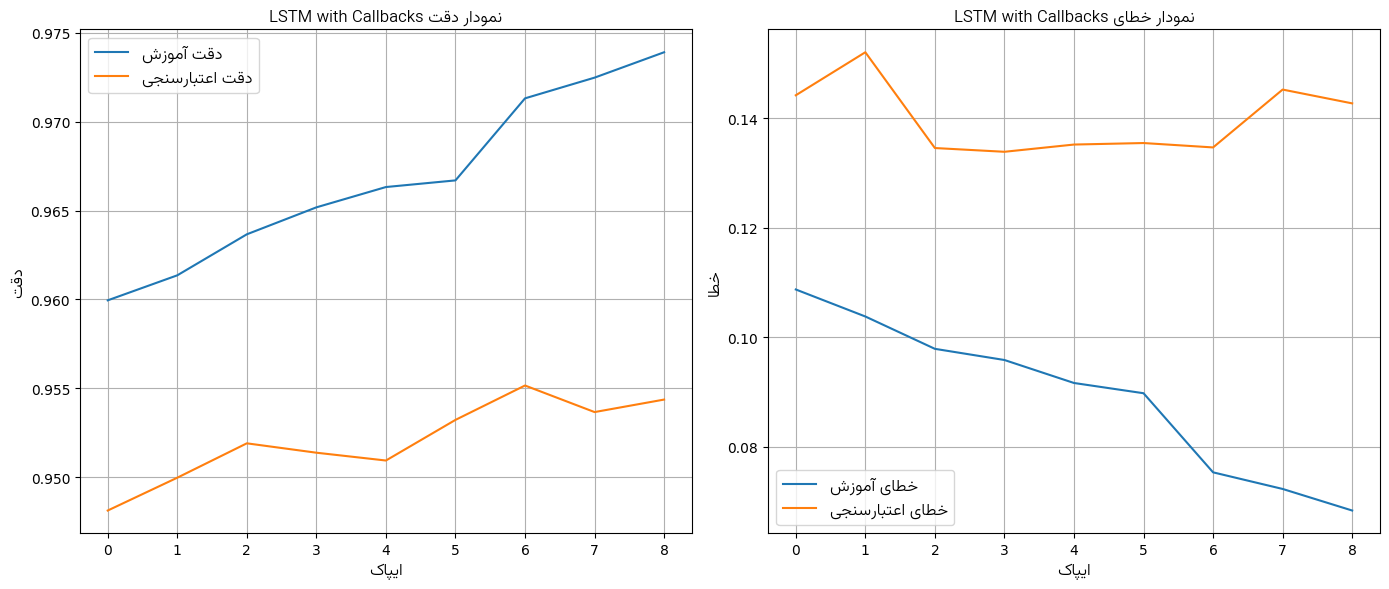

In [ ]:
early_stopping_cb = EarlyStopping(monitor='val_loss',
                                patience=5, # تعداد ایپاک برای انتظار قبل از توقف
                                verbose=1,
                                restore_best_weights=True) # بازگرداندن بهترین وزن‌ها

# کاهش نرخ یادگیری بر اساس عملکرد
reduce_lr_on_plateau_cb = ReduceLROnPlateau(monitor='val_loss',
                                           factor=0.2, # ضریب کاهش نرخ یادگیری (new_lr = lr * factor)
                                           patience=2, # تعداد ایپاک برای انتظار قبل از کاهش نرخ یادگیری
                                           verbose=1,
                                           min_delta=0.0001, # 
                                           min_lr=0.00001) # حداقل نرخ یادگیری

print(f"\n--- Training Model with Callbacks (Initial LR: {initial_learning_rate}) ---")
history_lstm_cb = lstm_model_cb.fit(X_train, y_train,
                                     epochs=20,  
                                     batch_size=64,
                                     validation_data=(X_test, y_test),
                                     callbacks=[early_stopping_cb, reduce_lr_on_plateau_cb], 
                                     verbose=1)
evaluate_model(lstm_model_cb, X_test, y_test, labels, model_name="LSTM with Callbacks")
plot_learning_curves(history_lstm_cb, model_name="LSTM with Callbacks")

In [ ]:
print("\n--- Defining Model 2: LSTM Version 1 ---")
def build_lstm_model_v1(embedding_matrix, max_sequence_length):
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0],
                        output_dim=embedding_matrix.shape[1],
                        weights=[embedding_matrix],
                        input_length=max_sequence_length,
                        trainable=False))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

lstm_model_v1 = build_lstm_model_v1(embedding_matrix, MAX_SEQUENCE_LENGTH)



--- Defining Model 2: LSTM Version 1 ---


f:\datamining-chapter3\New folder\venv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



--- Training Model 2: LSTM Version 1 ---
Epoch 1/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 113s 155ms/step - accuracy: 0.5573 - loss: 0.6869 - val_accuracy: 0.5577 - val_loss: 0.6866
Epoch 2/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 110s 154ms/step - accuracy: 0.5570 - loss: 0.6867 - val_accuracy: 0.5577 - val_loss: 0.6864
Epoch 3/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 128s 179ms/step - accuracy: 0.5537 - loss: 0.6875 - val_accuracy: 0.5577 - val_loss: 0.6866
Epoch 4/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 119s 167ms/step - accuracy: 0.5614 - loss: 0.6860 - val_accuracy: 0.5577 - val_loss: 0.6865
Epoch 5/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 120s 169ms/step - accuracy: 0.5554 - loss: 0.6871 - val_accuracy: 0.5577 - val_loss: 0.6864
Epoch 6/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 128s 179ms/step - accuracy: 0.5622 - loss: 0.6855 - val_accuracy: 0.5577 - val_loss: 0.6865
Epoch 7/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 113s 159ms/step - accuracy: 0.5620 - loss: 0.6859 - val_accuracy: 0.5577 - val_loss: 0.6864
Epoch 8/10
711/711 ━━━━━━━━━━━━━━━

f:\datamining-chapter3\New folder\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
f:\datamining-chapter3\New folder\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
f:\datamining-chapter3\New folder\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

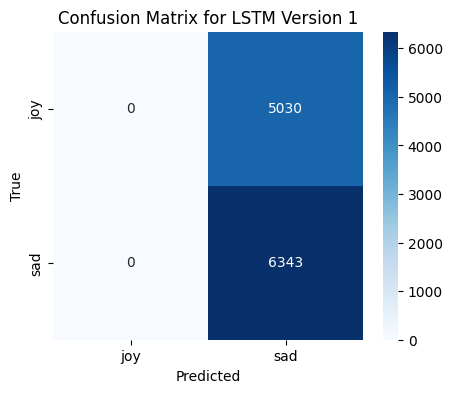

(0.5577244350655061, 0.3580379318130503)

In [28]:

print("\n--- Training Model 2: LSTM Version 1 ---")
history_lstm_v1 = lstm_model_v1.fit(X_train, y_train,
                                    epochs=10,
                                    batch_size=64,
                                    validation_data=(X_test, y_test),
                                    verbose=1)

evaluate_model(lstm_model_v1, X_test, y_test, labels, model_name="LSTM Version 1")

In [78]:
# مدل ۳: LSTM Version 2 
# -----------------------------------------------------------------------------
print("\n--- Defining Model 3: LSTM Version 2 ---")
def build_lstm_model_v2(embedding_matrix, max_sequence_length, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0],
                        output_dim=embedding_matrix.shape[1],
                        weights=[embedding_matrix],
                        input_length=max_sequence_length,
                        trainable=False))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax')) # خروجی سافت‌مکس برای sparse_categorical_crossentropy

    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=Adam(learning_rate=0.0001),
                  metrics=['accuracy'])
    return model

lstm_model_v2 = build_lstm_model_v2(embedding_matrix, MAX_SEQUENCE_LENGTH, num_classes=len(labels))



--- Defining Model 3: LSTM Version 2 ---


f:\datamining-chapter3\New folder\venv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



--- Training Model 3: LSTM Version 2 ---
Epoch 1/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 83s 103ms/step - accuracy: 0.6060 - loss: 0.6419 - val_accuracy: 0.8312 - val_loss: 0.3874
Epoch 2/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 102s 144ms/step - accuracy: 0.8368 - loss: 0.3800 - val_accuracy: 0.8517 - val_loss: 0.3487
Epoch 3/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 101s 142ms/step - accuracy: 0.8551 - loss: 0.3491 - val_accuracy: 0.8562 - val_loss: 0.3346
Epoch 4/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 83s 117ms/step - accuracy: 0.8626 - loss: 0.3329 - val_accuracy: 0.8690 - val_loss: 0.3181
Epoch 5/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 78s 110ms/step - accuracy: 0.8675 - loss: 0.3208 - val_accuracy: 0.8734 - val_loss: 0.3107
Epoch 6/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 78s 109ms/step - accuracy: 0.8717 - loss: 0.3121 - val_accuracy: 0.8748 - val_loss: 0.3019
Epoch 7/10
711/711 ━━━━━━━━━━━━━━━━━━━━ 112s 158ms/step - accuracy: 0.8756 - loss: 0.3030 - val_accuracy: 0.8755 - val_loss: 0.3012
Epoch 8/10
711/711 ━━━━━━━━━━━━━━━━━━━

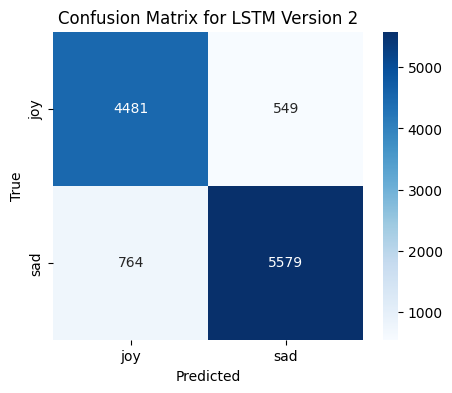

(0.884551129868988, 0.8834649262200714)

In [79]:

print("\n--- Training Model 3: LSTM Version 2 ---")
history_lstm_v2 = lstm_model_v2.fit(X_train, y_train,
                                    epochs=10,
                                    batch_size=64,
                                    validation_data=(X_test, y_test),
                                    verbose=1)

evaluate_model(lstm_model_v2, X_test, y_test, labels, model_name="LSTM Version 2")

Epoch 1/15
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 110s 86ms/step - accuracy: 0.8850 - loss: 0.2847 - val_accuracy: 0.9000 - val_loss: 0.2637
Epoch 2/15
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 104s 82ms/step - accuracy: 0.8928 - loss: 0.2731 - val_accuracy: 0.9011 - val_loss: 0.2569
Epoch 3/15
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 103s 80ms/step - accuracy: 0.8996 - loss: 0.2574 - val_accuracy: 0.8938 - val_loss: 0.2742
Epoch 4/15
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 104s 82ms/step - accuracy: 0.9001 - loss: 0.2564 - val_accuracy: 0.9046 - val_loss: 0.2490
Epoch 5/15
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 102s 79ms/step - accuracy: 0.9082 - loss: 0.2419 - val_accuracy: 0.8881 - val_loss: 0.2739
Epoch 6/15
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 102s 79ms/step - accuracy: 0.9104 - loss: 0.2341 - val_accuracy: 0.9101 - val_loss: 0.2419
Epoch 7/15
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 108s 84ms/step - accuracy: 0.9164 - loss: 0.2255 - val_accuracy: 0.9132 - val_loss: 0.2387
Epoch 8/15
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 99s 77ms/step - accuracy: 0

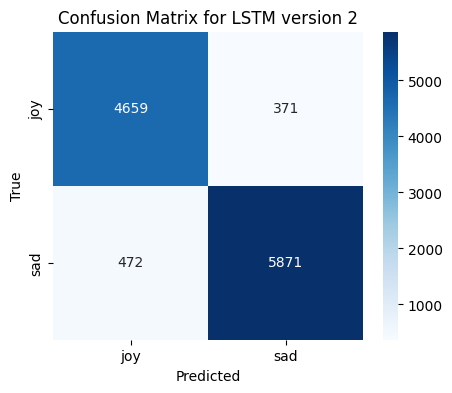

(0.9258770772883145, 0.9250256097333527)

In [80]:
# class_weights = {0: 1.0, 1: 1.2}  # Slightly favor the "sad" class if it's being ignored

# Add early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = lstm_model_v2.fit(X_train, y_train, 
                        epochs=15,  # A few more epochs with early stopping
                        batch_size=32,  # Smaller batch size for better learning
                        validation_split=0.1, 
                        # class_weight=class_weights,
                        callbacks=[early_stop],  # Add early stopping
                        verbose=1)

evaluate_model(lstm_model_v2, X_test, y_test, labels, model_name="LSTM version 2")

Epoch 1/15
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 117s 89ms/step - accuracy: 0.9347 - loss: 0.1985 - val_accuracy: 0.9292 - val_loss: 0.1974
Epoch 2/15
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 92s 71ms/step - accuracy: 0.9390 - loss: 0.1875 - val_accuracy: 0.9053 - val_loss: 0.2516
Epoch 3/15
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 112s 88ms/step - accuracy: 0.9403 - loss: 0.1809 - val_accuracy: 0.9264 - val_loss: 0.2062
Epoch 4/15
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 112s 87ms/step - accuracy: 0.9410 - loss: 0.1799 - val_accuracy: 0.9308 - val_loss: 0.1918
Epoch 5/15
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 101s 79ms/step - accuracy: 0.9439 - loss: 0.1756 - val_accuracy: 0.9273 - val_loss: 0.1996
Epoch 6/15
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 109s 85ms/step - accuracy: 0.9437 - loss: 0.1714 - val_accuracy: 0.9310 - val_loss: 0.1915
Epoch 7/15
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 115s 90ms/step - accuracy: 0.9466 - loss: 0.1668 - val_accuracy: 0.9301 - val_loss: 0.1916
Epoch 8/15
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 117s 91ms/step - accuracy: 0

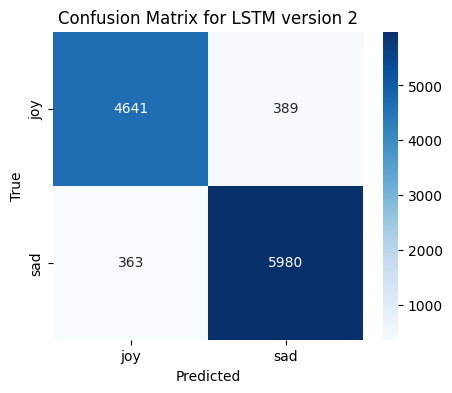

(0.9338784841290776, 0.9329490556525686)

In [ ]:
class_weights = {0: 1.2, 1: 1.0}  # Slightly favor the minor class

# Add early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = lstm_model_v2.fit(X_train, y_train, 
                        epochs=15,  # A few more epochs with early stopping
                        batch_size=32,  # Smaller batch size for better learning
                        validation_split=0.1, 
                        class_weight=class_weights,
                        callbacks=[early_stop],  # Add early stopping
                        verbose=1)

evaluate_model(lstm_model_v2, X_test, y_test, labels, model_name="LSTM version 2")

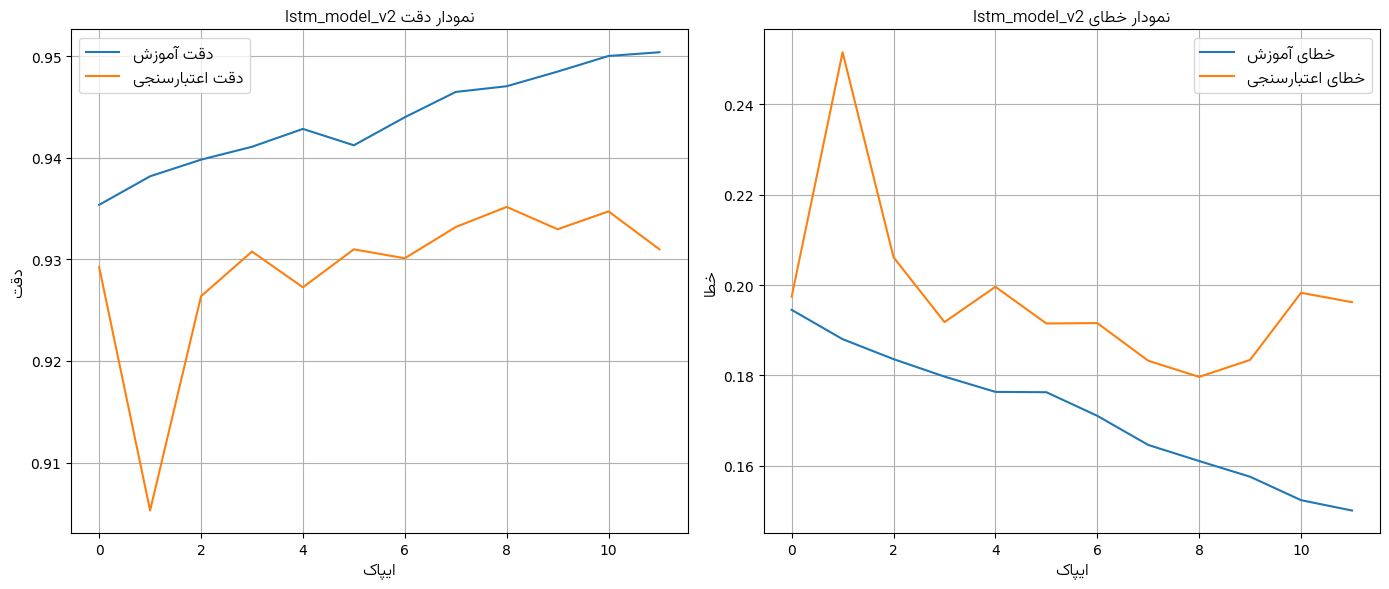

In [84]:
plot_learning_curves(history, model_name="lstm_model_v2")

In [51]:
model_save_path = 'saved_lstm_model_with_callbacks.h5' # اضافه کردن پسوند .h5
lstm_model_cb.save(model_save_path)

print(f"\nمدل در مسیر '{model_save_path}' ذخیره شد.")


مدل در مسیر 'saved_lstm_model_with_callbacks.h5' ذخیره شد.


In [ ]:
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


with open('max_sequence_length.pkl', 'wb') as f:
    pickle.dump(MAX_SEQUENCE_LENGTH, f)

classic ML approeches

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
import pandas as pd


texts = df_processed['full_text']
labels = df_processed['emotion_label']

# 2. Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42
)

# 3. Vectorize using TF-IDF
# TF-IDF (Term Frequency - Inverse Document Frequency) encodes how important a word is to a document
# It reduces the weight of common words and highlights distinguishing terms
# The result is a sparse matrix (text -> numeric features)
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,  # limit number of features (to reduce dimensionality)
    ngram_range=(1, 2),  # unigrams + bigrams to capture simple context
    lowercase=False      # texts are already normalized
)

# Fit and transform on training, only transform on test
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# 4. Train Naive Bayes model
# Multinomial Naive Bayes works well with text data and sparse counts/weights
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)

print("\n--- Naive Bayes Results ---")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("F1 Score (macro):", f1_score(y_test, y_pred_nb, average='macro'))
print(classification_report(y_test, y_pred_nb))

# 5. Train Decision Tree model
# Trees are more flexible but can overfit on high-dimensional sparse data
# So we limit depth and features for generalization

dt_model = DecisionTreeClassifier(max_depth=30, min_samples_leaf=10, random_state=42)
dt_model.fit(X_train_tfidf, y_train)
y_pred_dt = dt_model.predict(X_test_tfidf)

print("\n--- Decision Tree Results ---")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("F1 Score (macro):", f1_score(y_test, y_pred_dt, average='macro'))
print(classification_report(y_test, y_pred_dt))



--- Naive Bayes Results ---
Accuracy: 0.8568539523432691
F1 Score (macro): 0.8529156492572778
              precision    recall  f1-score   support

         joy       0.88      0.78      0.83      5030
         sad       0.84      0.91      0.88      6343

    accuracy                           0.86     11373
   macro avg       0.86      0.85      0.85     11373
weighted avg       0.86      0.86      0.86     11373


--- Decision Tree Results ---
Accuracy: 0.9616635892024972
F1 Score (macro): 0.9611970941102489
              precision    recall  f1-score   support

         joy       0.95      0.96      0.96      5030
         sad       0.97      0.96      0.97      6343

    accuracy                           0.96     11373
   macro avg       0.96      0.96      0.96     11373
weighted avg       0.96      0.96      0.96     11373



In [ ]:
if hasattr(dt_model, 'feature_importances_'):
    # Get feature names
    feature_names = np.array(tfidf_trigram.get_feature_names_out())
    
    # Get feature importances
    importances = dt_model.feature_importances_
    
    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]
    
    # Print the top 20 most important features
    print("\nTop 20 most important features:")
    for i in range(min(20, len(indices))):
        print(f"{feature_names[indices[i]]}: {importances[indices[i]]:.4f}")


In [18]:
tfidf_trigram = TfidfVectorizer(
    max_features=15000,  # limit number of features (to reduce dimensionality)
    ngram_range=(1,3),  # unigrams + bigrams + trigram to capture simple context
    lowercase=False      # texts are already normalized
)

In [19]:
X_train_trigram = tfidf_trigram.fit_transform(X_train)
X_test_trigram = tfidf_trigram.transform(X_test)

In [20]:
nb_model = MultinomialNB()
nb_model.fit(X_train_trigram, y_train)
y_pred_nb_trigram = nb_model.predict(X_test_trigram)

print("\n--- Naive Bayes Results ---")
print("Accuracy:", accuracy_score(y_test, y_pred_nb_trigram))
print("F1 Score (macro):", f1_score(y_test, y_pred_nb_trigram, average='macro'))
print(classification_report(y_test, y_pred_nb_trigram))



--- Naive Bayes Results ---
Accuracy: 0.8494680383364108
F1 Score (macro): 0.8452159846471519
              precision    recall  f1-score   support

         joy       0.87      0.77      0.82      5030
         sad       0.83      0.91      0.87      6343

    accuracy                           0.85     11373
   macro avg       0.85      0.84      0.85     11373
weighted avg       0.85      0.85      0.85     11373



In [21]:
dt_model = DecisionTreeClassifier(
    max_depth=30,
    min_samples_leaf=10,
    # max_features='sqrt',
    # criterion='entropy',
    # class_weight='balanced',
    random_state=42
)
dt_model.fit(X_train_trigram, y_train)
y_pred_dt_trigram = dt_model.predict(X_test_trigram)

print("\n--- Decision Tree Results ---")
print("Accuracy:", accuracy_score(y_test, y_pred_dt_trigram))
print("F1 Score (macro):", f1_score(y_test, y_pred_dt_trigram, average='macro'))
print(classification_report(y_test, y_pred_dt_trigram))



--- Decision Tree Results ---
Accuracy: 0.9627187197749055
F1 Score (macro): 0.9622650639971227
              precision    recall  f1-score   support

         joy       0.95      0.96      0.96      5030
         sad       0.97      0.96      0.97      6343

    accuracy                           0.96     11373
   macro avg       0.96      0.96      0.96     11373
weighted avg       0.96      0.96      0.96     11373




--- Training and Evaluating the Final Decision Tree Model ---
Final Model Accuracy (Test): 0.9627187197749055
Final Model Training Accuracy: 0.9718

--- Generating Learning Curve Data ---

--- Plotting Learning Curve using LearningCurveDisplay ---


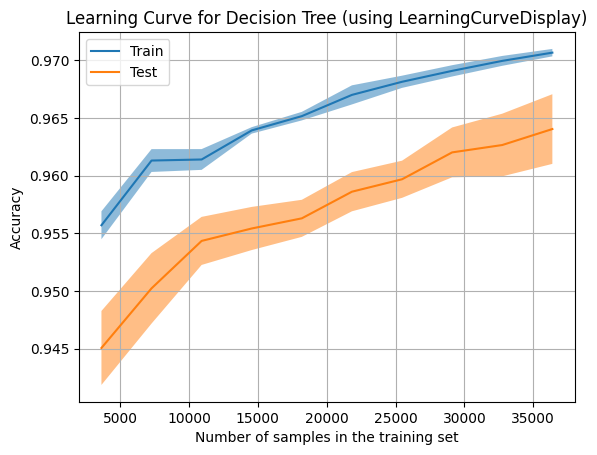


Interpretation Guide for Learning Curve (Decision Tree):
1. Large Gap (Training score >> Cross-validation score): Strong indicator of overfitting.
2. Low Scores for Both: Indicates underfitting.
3. Convergence: Ideally, the validation score should increase and get closer to the training score.
Also, compare the 'Final Model Training Accuracy' (0.9718) with your 'Final Model Accuracy (Test)'.


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve, LearningCurveDisplay # LearningCurveDisplay اضافه شد
from sklearn.metrics import accuracy_score, f1_score, classification_report
import time

# --- تعریف مدل Decision Tree شما ---
def create_dt_model():
    return DecisionTreeClassifier(
        max_depth=30,
        min_samples_leaf=10,
        random_state=42
    )

# --- فرض می‌کنیم X_train_trigram و y_train و y_test از قبل آماده هستند ---
# --- و X_test_trigram هم آماده است ---

# --- آموزش و ارزیابی مدل نهایی (برای داشتن معیار) ---
print("\n--- Training and Evaluating the Final Decision Tree Model ---")
dt_model_final = create_dt_model()
dt_model_final.fit(X_train_trigram, y_train)
y_pred_dt_trigram = dt_model_final.predict(X_test_trigram)
train_accuracy_dt_final_model = accuracy_score(y_train, dt_model_final.predict(X_train_trigram))

print("Final Model Accuracy (Test):", accuracy_score(y_test, y_pred_dt_trigram))
print(f"Final Model Training Accuracy: {train_accuracy_dt_final_model:.4f}")


# --- محاسبه داده‌های منحنی یادگیری (این بخش تغییر چندانی نمی‌کند) ---
print("\n--- Generating Learning Curve Data ---")
train_sizes_abs_dt, train_scores_dt, validation_scores_dt = learning_curve(
    estimator=create_dt_model(),
    X=X_train_trigram,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10), # می‌توانید تعداد نقاط را برای سرعت بیشتر کم کنید
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)


print("\n--- Plotting Learning Curve using LearningCurveDisplay ---")
disp = LearningCurveDisplay(
    train_sizes=train_sizes_abs_dt,
    train_scores=train_scores_dt,
    test_scores=validation_scores_dt, # توجه: در اینجا test_scores همان validation_scores است
    score_name="Accuracy" # نام معیاری که نمایش داده می‌شود (اختیاری)
)
disp.plot() 
plt.title("Learning Curve for Decision Tree (using LearningCurveDisplay)")
plt.grid(True)
plt.show()

# راهنمای تفسیر همچنان معتبر است
print(f"\nInterpretation Guide for Learning Curve (Decision Tree):")
print(f"1. Large Gap (Training score >> Cross-validation score): Strong indicator of overfitting.")
print(f"2. Low Scores for Both: Indicates underfitting.")
print(f"3. Convergence: Ideally, the validation score should increase and get closer to the training score.")
print(f"Also, compare the 'Final Model Training Accuracy' ({train_accuracy_dt_final_model:.4f}) with your 'Final Model Accuracy (Test)'.")

In [22]:
import pickle

with open("final_decision_tree_model.pkl", "wb") as f:
    pickle.dump(dt_model_final, f)  


In [23]:
import pickle

with open("vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf_trigram, f)


In [ ]:
import pickle
import numpy as np
from tensorflow.keras.models import load_model


with open('final_decision_tree_model.pkl', 'rb') as f:
    dt_model_final = pickle.load(f)

with open('vectorizer.pkl', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)

with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

with open('max_sequence_length.pkl', 'rb') as f:
    max_seq_length = pickle.load(f)

lstm_model_cb = load_model('saved_lstm_model_with_callbacks.h5')


sample_text = "من درد مشترکم مرا فریاد کن"


cleaned_text = preprocess_persian_tweet(sample_text)

# === Predict with Decision Tree ===
text_tfidf = tfidf_vectorizer.transform([cleaned_text])
dt_pred = dt_model_final.predict(text_tfidf)[0]

# === Predict with LSTM ===
sequence = tokenizer.texts_to_sequences([cleaned_text])
padded_seq = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=max_seq_length, padding='post')
lstm_pred_prob = lstm_model_cb.predict(padded_seq)[0][0]
lstm_pred = int(round(lstm_pred_prob))

# === Show Results ===

labels = {0: "joy", 1: "sad"}

# Reverse lookup too, just in case model returns "sad"
reverse_labels = {"joy": 0, "sad": 1}

# Handle Decision Tree output
if isinstance(dt_pred, str):
    dt_label = dt_pred
    dt_pred_num = reverse_labels[dt_pred]
else:
    dt_pred_num = int(dt_pred)
    dt_label = labels[dt_pred_num]

# Handle LSTM output
lstm_pred = int(round(lstm_pred_prob))
lstm_label = labels[lstm_pred]

# Display
print("📘 Sample Input:", sample_text)

print("\nDecision Tree:")
print("  ➤ Raw Prediction:", dt_pred)
print("  ➤ Interpreted:", dt_label)

print("\nLSTM Model:")
print("  ➤ Raw Prediction (probability):", lstm_pred_prob)
print("  ➤ Rounded Prediction:", lstm_pred)
print("  ➤ Interpreted:", lstm_label)
